## Spotify Billboard 200 Second Impression

Refer to `bb200_first_impressions.ipynb` for the initial run-through and analysis of the features. In this notebook, we will quickly prepare the data for modeling in the same way we did in the first notebook, but perform some feature selection on our data. In the first notebook, we successfully fit a single decision tree with 75% cross-validated and out of sample accuracies; we will reuse its parameters during our feature selection process, try some over-under sampling, and then proceed to use AdaBoost to see if we can get additional predictive power through additive classifying trees.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
sns.set()
%matplotlib inline

### Data preprocessing

As in `bb200_first_impressions.ipynb`, we first preprocess our data to deal with the missing values and standardize our continuous features.

**Remark.** Refer to `bb200_first_impressions.ipynb` for why exactly the code is as it is below.

In [18]:
# raw data
af_raw = pd.read_csv("./data/acoustic_features.csv")
# amend missing data
af_raw.iloc[241999, 3] = "Kenny G"
af_raw.loc[pd.isna(af_raw["artist"]), af_raw.columns == "artist"] = "Various Artists"
# create X and y; note that y is categorical now
X = af_raw.loc[:, af_raw.columns != "danceability"].dropna().copy()
y = pd.DataFrame(map(lambda x : 1 if x > 0.5 else 0, af_raw["danceability"].dropna()),
                columns = ["danceable"], index = X.index)
# standardize continuous features (we might want to run other models later)
cont_cols = ["acousticness", "duration_ms", "energy", "instrumentalness", "liveness", 
             "loudness", "speechiness", "tempo", "valence"]
# scale continuous columns and make new DataFrame out of them
sscl = StandardScaler()
Xs_cont = pd.DataFrame(sscl.fit_transform(X[cont_cols]), columns = cont_cols)
# get dummies for key and time_signature (mode is already 1 for major, 0 for minor)
# we ignore mode since mode is 1 for major, 0 for minor
cat_cols = ["key", "time_signature"]
# get dummies for each of the columns; need to map to string to be treated as categorical
X_cat = None
for cc in cat_cols:
    ccat = pd.get_dummies(pd.DataFrame(map(lambda x: str(int(x)), X[cc]), columns = [cc]), 
                          prefix = cc[:3])
    if X_cat is None: X_cat = ccat
    else: X_cat = X_cat.merge(ccat, how = "outer", left_index = True, right_index = True)
# merge standardized continuous features with categorical features
X = Xs_cont.merge(X_cat, how = "outer", left_index = True, right_index = True)
# check shapes of X, y
print("X shape: {0}\ty shape: {1}".format(X.shape, y.shape))
# preview X
X.head()

X shape: (339850, 26)	y shape: (339850, 1)


,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_5,key_6,key_7,key_8,key_9,tim_0,tim_1,tim_3,tim_4,tim_5
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590,0,...,0,1,0,0,0,0,0,0,1,0
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669,0,...,0,1,0,0,0,0,0,0,1,0


Now we are ready to do some cross-validated feature selection using the same decision tree we tuned in `bb200_fist_impressions.ipynb`.

### CV feature selection: decision tree

We tuned the decision tree already, so we will use the same hyperparameters and instead focus on selecting features. As usual, we do an 80-20 training and test split, and cross-validate on the training portion to select our features before reporting test performance. Again, we choose accuracy as the criterion, and perform 5-fold cross-validation on our training data during our feature selection.

**Remark.** The entire feature selection process takes around ~15 minutes on my machine, using 2 cores. Results may vary.

In [22]:
# create tuned decision tree and RFECV objects with 5-fold CV
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 25, max_features = "auto",
                             min_samples_split = 40)
dtc_rfecv = RFECV(dtc, cv = 5, scoring = "accuracy", verbose = 1, n_jobs = 2)
# 80/20 train test split and feature selection on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
dtc_rfecv.fit(X_train, y_train)

c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFECV(cv=5,
      estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                       max_depth=25, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=40,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=None,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

Now that we have pruned our feature matrix, let's see which features were selected during feature elimination, and how many of them we have.

In [28]:
sfdf = X.columns[dtc_rfecv.support_]
print("{0}\n{1} selected features".format(sfdf, len(sfdf)))

Index(['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'tim_4'],
      dtype='object')
10 selected features


We have thus gone from 26 features to 10 features. Interestingly, most of our categorical features have been dropped. Let us check our cross-validated training and our holdout test accuracies to see if there is any meaningful difference between the two.

In [29]:
print("train accuracy:\t{0:.5f}\ntest accuracy:\t{1:.5f}".format(dtc_rfecv.score(X_train, y_train), 
                                                                 dtc_rfecv.score(X_test, y_test)))

train accuracy:	0.84893
test accuracy:	0.75457


Hm, it looks like our tree has overfit a lot more than we have liked it to, as we have nearly a 10% decrease in accuracy on the test data. However, this test accuracy is still about the same as what we had for our decision tree in `bb200_first_impressions.ipynb`, and using far fewer features.

### Over-under sampling: decision tree

In a previous semester, my BAC group had shown that using the `imblearn` method `SMOTEENN`, a combination of using the SMOTE (Synthetic Minority Oversampling TEchnique) algorithm with edited nearest neighbors, helped to improve the accuracy of a decision tree trained on a multi-class data set with unbalanced class proportions. We show the same plot as in `bb200_first_impressions.ipynb` to show the minority class imbalance.

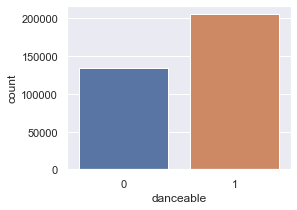

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(y["danceable"], ax = ax)

However, only `SMOTENC`, a vanilla SMOTE implementation for both categorical and continuous data, can be used given the presence of categorical features. But as was revealed from recursive feature elimination, only one of the categorical features, `tim_4`, which indicates that a song has 4 beats per measure, was included among our 10 selected features. Let's drop that feature to create our reduced feature matrix `Xr`, and then apply `SMOTEENN`.

In [33]:
Xr = X[sfdf[:-1]].copy()
Xr.head()

,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669


`SMOTEEN` will give us a modified `Xr` which we will call `Xm` and a modified `y` which we will call `ym`. Now that we have our resampled data, we will perform a grid search to tune a single decision tree to see how it may affect our results. Then, we may move to using AdaBoost to create an additive tree model. (0240)

**Remark.** This cell took around 3 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [52]:
# use constant seed for test purposes and balance classes equally. [try] to run on 
# two threads (not guaranteed) as multithreading not necessarily possible due to 
# python's (notorious?) global interpreter lock
sme = SMOTEENN(sampling_strategy = 1, random_state = 11, n_jobs = 2)
# check shape pre-resample
print("Xr shape: {0}\ty shape: {1}".format(Xr.shape, y.shape))
# resample to equally balance classes; put ym back in DataFrame
Xm, ym = sme.fit_resample(Xr, y)
ym = pd.DataFrame(ym, columns = ["danceable"])
# check shape post-resample
print("Xm shape: {0}\tym shape: {1}".format(Xm.shape, ym.shape))

Xr shape: (339850, 9)	y shape: (339850, 1)


c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Xm shape: (236555, 9)	ym shape: (236555, 1)


We quickly check the class frequencies in our new modified response vector `ym`.

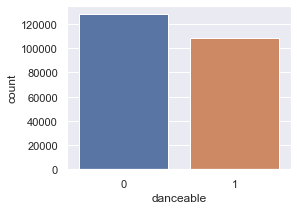

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(ym["danceable"], ax = ax)

We perform the usual 80/20 `train_test_split` to get our training and test partitions, and perform a 5-fold cross-validated grid search using `GridSearchCV` to tune the parameters of our single decision tree. Again, we use accuracy as the scoring statistic.

**Remark.** This cell took around 4 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [54]:
# again, we use constant random state for testing purposes
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size = 0.2, random_state = 7)
# new decision tree classifier; again use entropy
dtc = DecisionTreeClassifier(criterion = "entropy")
# same parameter grid as in bb200_first_impressions.ipynb but with some added values
param_grid = {"min_samples_split": [2, 10, 20, 40, 50], 
              "max_depth": [20, 25, 50, None], 
              "max_features": ["auto", None]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
dtc_gscv = GridSearchCV(dtc, param_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
dtc_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   53.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': [20, 25, 50, None],
                         'max_features': ['auto', None],
                     

As usual, we check the average cross-validated training score (accuracy) and the test score of the best fitted tree.

In [55]:
# our best decision tree estimator
dtc_best = dtc_gscv.best_estimator_
print("5-fold CV grid accuracy:\t{0:.5f}\nbest tree grid accuracy:\t{1:.5f}\n"
      "best tree test accuracy:\t{2:.5f}"
      "".format(dtc_gscv.cv_results_["mean_test_score"].mean(), dtc_gscv.best_score_, 
                dtc_best.score(Xm_test, ym_test)))
# our best decision tree estimator
dtc_best

5-fold CV grid accuracy:	0.91193
best tree grid accuracy:	0.91617
best tree test accuracy:	0.92177


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Wow! This is a **dramatic** improvement over the 75% we were getting earlier! And it shows that we are not overfitting either, as our test accuracy is even slightly better than the training cross-validated accuracy. Hooray! We create a confusion matrix to check misclassification rates, which are looking quite good; they are a dramatic improvement over what we saw in `bb200_first_impressions.ipynb`. So far, it looks like we have the ideal tree to begin boosting.

In [102]:
# our confusion matrix
cmat = confusion_matrix(ym_test, dtc_best.predict(Xm_test))
print("misclassification rate for 0: {0:.5f}\nmisclassification rate for 1: {1:.5f}"
      "".format(cmat[0][1] / sum(cmat[0]), cmat[1][0] / sum(cmat[1])))

misclassification rate for 0: 0.07299
misclassification rate for 1: 0.08438


To show some additional metrics, we show the model's precision, compute its AUC, and visualize the confusion matrix with its ROC curve.

best tree test precision:	0.91441
best tree test AUC:		0.92132


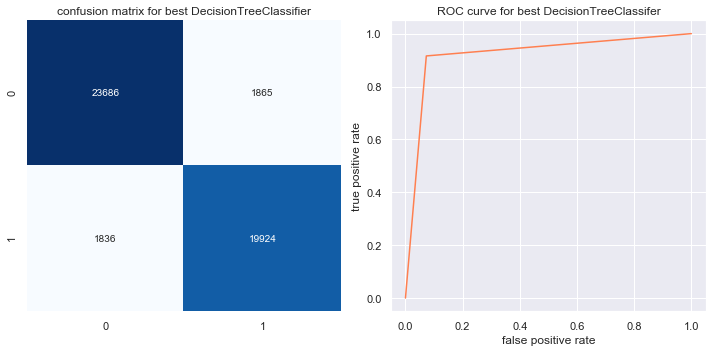

In [112]:
# predicted values from test feature matrix
ym_test_pred = dtc_best.predict(Xm_test)
print("best tree test precision:\t{0:.5f}\nbest tree test AUC:\t\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axs[0].set_title("confusion matrix for best DecisionTreeClassifier")
sns.heatmap(cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best DecisionTreeClassifer")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

For a single, not too deep decision tree classifier, this is pretty good. The ROC curve could use some work, but considering that we were starting out from 75%, we have come quite far. In the next section, we will move to try and increase our accuracy just a little bit more by using AdaBoost to create an additive model out of individual trees. But if we are happy with 92% accuracy and this ROC curve, we can stop here.

### Boosting with AdaBoost: decision tree